In [1]:
from notebook_tools import *
from scipy import optimize

%matplotlib inline

# pp-SRC analysis

In [2]:
columns = ['Q2' , 'Xb' , 'p/q' ,'theta (pq)' , 'Mmiss' ,'Pmiss3Mag','pcmX','pcmY','pcmZ' , 'rooWeight' ,
          'theta (rec-q)' , 'OpeningAngle']
targets = ['C12','Al27','Fe56','Pb208']
colors = ['red','blue','purple','black']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'] 
ana = dict()
for target in targets:
    ana[target] = read_root( "/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target , key='anaTree' , columns=columns  )


In [3]:
def gauss_func(x, C , mean, sigma):
    return C/np.sqrt(2*np.pi*sigma)*np.exp( -np.square(x-mean)/(2*np.square(sigma)) )

In [5]:
# runs 10,000 - 72,500
AccCorr = pd.DataFrame({'A':[12 , 27 , 56 , 208],
                        's_t_AccCorr':[160,157,182,175],
                        's_t_AccCorrErr':[9,18,9,15]},index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
# c.m. resolution correction
AccCorr['s_t_final'] = np.sqrt( np.square(AccCorr['s_t_AccCorr']) - np.square(20))
AccCorr['s_t_final_Err'] = np.sqrt( np.square(AccCorr['s_t_AccCorrErr']) + np.square(5))

AccCorr

,A,s_t_AccCorr,s_t_AccCorrErr,s_t_final,s_t_final_Err
$^{12}$C,12,160,9,158.745079,10.295630
$^{27}$Al,27,157,18,155.720904,18.681542
$^{56}$Fe,56,182,9,180.897761,10.295630
$^{208}$Pb,208,175,15,173.853387,15.811388


standard deviation: 0.165, fit sigma: 0.165 +/- 0.005
158.745078664 10.295630141
standard deviation: 0.171, fit sigma: 0.171 +/- 0.009
155.720904184 18.6815416923
standard deviation: 0.174, fit sigma: 0.174 +/- 0.005
180.89776118 10.295630141
standard deviation: 0.199, fit sigma: 0.199 +/- 0.012
173.853386507 15.8113883008


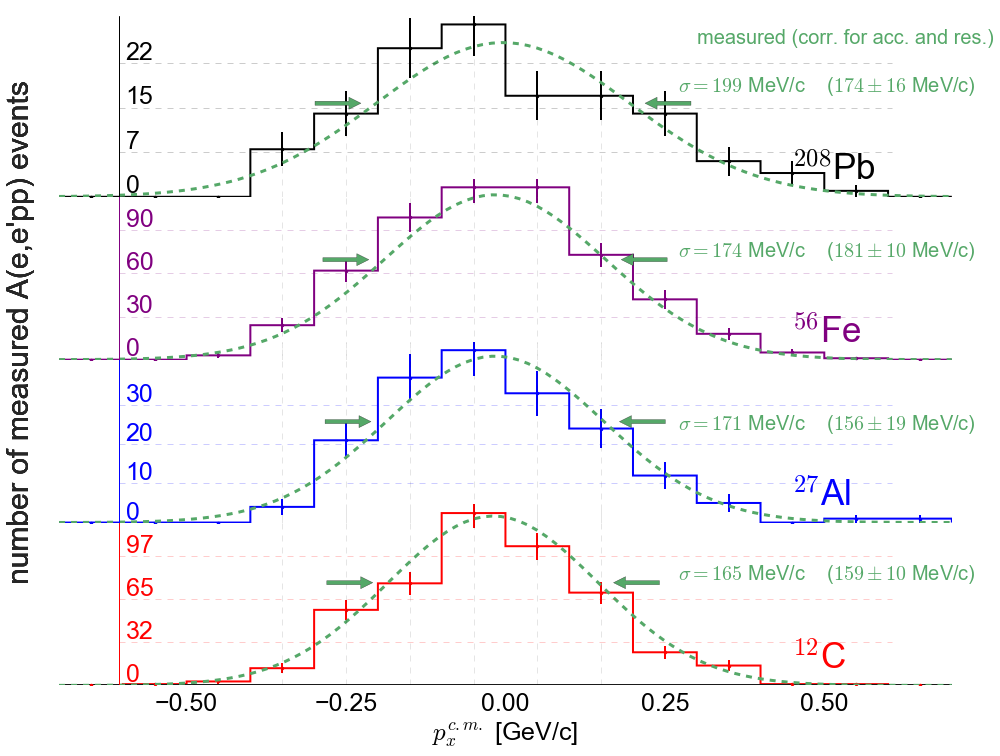

In [25]:
# make p(c.m.) in a nice style using also keyone
xmin , xmax , nbins = -0.7,0.7, 15
bins=np.linspace(xmin , xmax , nbins )
figsize=(16,12)

fig = plt.figure(figsize=figsize)


for i,target,target_name,color in zip(range(4),targets,target_names,colors):
    x = ana[target].pcmX#np.sqrt(0.5)*(ana[target].pcmX + ana[target].pcmY)
    x_label_='$p^{c.m.}_{x}$ [GeV/c]'  # = (p^{c.m.}_{x}+p^{c.m.}_{y})/2
    
    mean = np.average(x)
    sigma = np.sqrt(np.average(np.square(x-mean)))
        
    ax = fig.add_subplot(4,1,4-i)
    h,bins,_=plt.hist(x,bins=bins,histtype='step',linewidth=2,color=color);
    mid = bins[0:-1] + 0.5*(bins[1]-bins[0])
    plt.errorbar( mid , y=h , yerr=np.sqrt(h) , fmt='.',linewidth=2 , color=color);
    C = np.max(h)
    
    # Fit the set
    fana = TAnalysisEG2( "/Users/erezcohen/Desktop/DataMining/AnaFiles" , "Ana_ppSRCcut_DATA_%s"%target )
    roofits = fana.RooFitCM( 0.2 , 1.1 , False , False , 2 )
    df = pd.DataFrame({'mean_x':roofits[0],'mean_xErr':roofits[1],'sigma_x':roofits[2],'sigma_xErr':roofits[3]                                      
                   ,'mean_y':roofits[4],'mean_yErr':roofits[5],'sigma_y':roofits[6],'sigma_yErr':roofits[7]}                                       
                   , index=[i])
    roofit_sigma , roofit_sigmaErr = float(df.sigma_x),float(df.sigma_xErr)
    print 'standard deviation: %.3f, fit sigma: %.3f +/- %.3f'%(sigma,roofit_sigma , roofit_sigmaErr)

    x_gaus = np.linspace(np.min(bins),np.max(bins),100)
    y_gaus = C/np.sqrt(2*np.pi*sigma)*np.exp( -np.square(x_gaus-mean)/(2*np.square(roofit_sigma)) )
    plt.plot(x_gaus,y_gaus,'g--',linewidth=3);

    y_sigma = C/np.sqrt(2*np.pi*sigma)*np.exp(-0.5)

    ymax = 1.05*np.max([np.max(h),C/np.sqrt(2*np.pi*sigma)])
    ax.set_ylim(0,ymax)

    if i==0:
        x_label=x_label_
        plt.axhspan(xmin=-1,xmax=1,ymin=0,ymax=0,linewidth=3)

    else:
        x_label=''
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.set_axis_off()

    plt.text(xmax-0.25 , 0.1*np.max(h) , target_name , color=color , fontsize=35)
    ax.set_xlim(xmin , xmax)
    plt.xticks(np.linspace(xmin + 0.2 , xmax - 0.2 , 5))
    set_axes(ax,x_label=x_label,fontsize=25)
    plt.subplots_adjust(hspace=-0.1)
    


    # add grid lines
    for j,tick in zip(range(len(mid)),mid):
        if j < 3 or j > nbins-7:
            continue 
        if i==2  :
            y_max = 0.9*ymax # h[j]
        elif i==3:
            y_max = h[j]
        else:
            y_max = ymax
        line = plt.Line2D([tick,tick],[0,y_max],linewidth=1,linestyle='--',color='black',alpha=0.1)
        ax.add_artist(line)


    # add x-axis to the bottom subplot (12C)
    if i==0:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(labeltop='off', labelleft='off')
        customaxis(ax,c_left='none',c_bottom='none')


    # add vertical axes
    x_yaxis = xmin + 0.0675*(xmax-xmin)*(1-0.2*i*0)
    line = plt.Line2D([x_yaxis,x_yaxis],[0,ymax],linewidth=1,linestyle='-',color=color)
    ax.add_artist(line)
    if (ymax/10)%2==1:
        y_max = ymax-ymax%20
    else:
        y_max = ymax-ymax%10
    for y_tick in np.arange(0,y_max,y_max/4):
        
        ax.text(x_yaxis+0.01,y_tick+0.02*y_max,'%d'%y_tick,fontsize=25,color=color)
        line = plt.Line2D([x_yaxis,-x_yaxis],[y_tick,y_tick],linewidth=1,linestyle='--',color=color,alpha=0.2)
        ax.add_artist(line)

    # add sigma lines and text
    if i==3:
        plt.text(xmax-0.4,y_sigma+10,'measured (corr. for acc. and res.)',color='g',fontsize=20)
    s_t_final , s_t_final_Err = float(AccCorr[AccCorr.index==target_name]['s_t_final']),float(AccCorr[AccCorr.index==target_name]['s_t_final_Err'])
    print s_t_final , s_t_final_Err
    y_text = y_sigma+2 if i!=1 else y_sigma-2
    plt.text(xmax-0.43,y_text,'$\\sigma=%.0f$ MeV/c    ($%.0f \pm %.0f$ MeV/c)'%(1000*roofit_sigma,s_t_final , s_t_final_Err),color='g',fontsize=20)
    ax.annotate('', xy=(mean+sigma+0.02, y_sigma), xytext=(mean+sigma+0.1, y_sigma),arrowprops=dict(facecolor='g', shrink=0.05))
    ax.annotate('', xy=(mean-sigma-0.02, y_sigma), xytext=(mean-sigma-0.1, y_sigma),arrowprops=dict(facecolor='g', shrink=0.05))


    plt.figtext(0.08,0.8,"number of measured A(e,e'pp) events",fontdict={'fontsize':30},rotation=90)
    plt.savefig('/Users/erezcohen/Desktop/DataMining/2NSRC/ppSRCcmPaper/Figures/pcm_alltargets.pdf')
        